# Project 2
## Lawrence Liu Jackie McGinley

# Background
#### A large company named Canterra, employs, at any given point of time, around 4000 employees. However, every year, around 15% of its employees leave the company and need to be replaced with the talent pool available in the job market. The management believes that this level of attrition (employees leaving, either on their own or because they got fired) is bad for the company, because of the following reasons:
- The former employees’ projects get delayed, which makes it difficult to meet timelines, resulting in a reputation loss among consumers and partners
- A sizable department has to be maintained, for the purposes of recruiting new talent
- More often than not, the new employees have to be trained for the job and/or given time to acclimatize themselves to the company
#### The management hypothesizes that higher job satisfaction and a higher number of total working years will reduce employee attrition. Additionally, the marketing management was interested to know if demographic variables such as gender, education and age affect employee attrition. Hence, the management has contracted you as a consultant to understand whether these two factors they should focus on, in order to curb attrition. In other words, they want to know if changes in their internal and external recruitment strategies would help retain employees.



In [135]:
### Step 0: Setup ----
# Load any libraries used for this project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    roc_curve,
    roc_auc_score
)
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
# for stepwise selection later
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LogisticRegression


In [ ]:
# -------------------------------------------------------------------
# Step 1: Pre-processing
# -------------------------------------------------------------------

print("Do we have missing values? Look at 'Non-Null Count'")
df = pd.read_excel('Employee_Data_Project.xlsx')
df.shape
print(df.info())


#### There are missing values in the NumCompaniesWorked , TotalWorkingYears , EnvironmentSatisfaction , JobSatisfaction Columns

In [ ]:
# -------------------------------------------------------------------
# Step 1: Pre-processing (check rows with nulls and visualize those rows)
# -------------------------------------------------------------------
# first step is to get the index of where the nulls are and take a look at only those rows
null_rows = df[df.isnull().any(axis=1)].index
# use the index from null rows to view those rows
df.loc[null_rows]
## confirmed that there are truly NaNs (73 total rows have NaNs)

- 1.65% of the data is missing, to will do train test split then impute the missing values. 

In [ ]:
medians = {'NumCompaniesWorked': df['NumCompaniesWorked'].median(), 'TotalWorkingYears': df['TotalWorkingYears'].median(),
    'EnvironmentSatisfaction': df['EnvironmentSatisfaction'].median(), 'JobSatisfaction': df['JobSatisfaction'].median()}
df = df.fillna(medians)
df.info()

#### replaced the null values in NumCompaniesWorked , TotalWorkingYears , EnvironmentSatisfaction , JobSatisfaction Columns with the median as these were numerical data types

---

#### encode attrition 


In [ ]:
    
df['Attrition'] = (df['Attrition'] == "Yes").astype(int)


In [ ]:
# -------------------------------------------------------------------
# Step 2: Train Test Split
# -------------------------------------------------------------------
X = df.drop(['Attrition','EmployeeID', 'StandardHours'], axis =1)
y = df['Attrition']

X_train , X_test, y_train, y_test = train_test_split(
    X, y, test_size  = 0.3, random_state = 42 , stratify= y
)

X_train.info



- categorical columns:  BusinessTravel , Gender, MaritalStatus
- Numerical Columns: Age, DistanceFromHome , Education , Gender , JobLevel , Income , NumCompaniesWorked , TotalWorkingYears , TrainingTimesLastYear , YearsAtCompany , YearsWithCurrManager , EnvironmentSatisfaction, JobSatisfaction

In [ ]:
categorical_columns = ['BusinessTravel', 'Gender', 'MaritalStatus']
X_train_encoded = pd.get_dummies(X_train, columns=categorical_columns, drop_first=True, dtype=int)
X_test_encoded = pd.get_dummies(X_test, columns = categorical_columns, drop_first= True, dtype = int )

#### regarding the newly enconded columns 
- When Gender_Male = 1 , then Male. Gender_Male = 0, then Female 
- When MaritalStatus_Married = 1 , then Married 
- When MaritalStatus_Single = 1 , then Single 
- When both MaritalStatus_Married and MaritalStatus_Single are 0, then Divorced 
- When BusinessTravel_Travel_Frequently = 1, then Travel Frequently
- When BusinessTravel_Travel_Rarely = 1, then Travel Rarely 
- When both BusinessTravel_Travel_Frequently and BusinessTravel_Travel_Rarely are 0, then Non Travel

---

#### now that the categorical variables are encoded. The numerical columns will be defined (possbly min-max scaling)

In [ ]:
numerical_columns = ['Age', 'DistanceFromHome' , 'Education' , 'Gender', 'JobLevel' , 'Income' , 
'NumCompaniesWorked' , 'TotalWorkingYears' , 'TrainingTimesLastYear' , 'YearsAtCompany' , 'YearsWithCurrManager' ,
 'EnvironmentSatisfaction', 'JobSatisfaction']

---

In [ ]:
f1 = sm.Logit(y_train, sm.add_constant(X_train_encoded['Age'])).fit()
print("\n=== f1 summary ===")
print(f1.summary())

In [ ]:
# ROC/AUC/Precision/Recall on original (unbalanced) TRAIN set, using probabilities

# Predicted probabilities on TRAINING data (not test!)
train_probs = f1.predict(sm.add_constant(X_train_encoded['Age']))

# Calculate precision and recall
train_pred_class = (train_probs >= 0.5).astype(int)

cm_train = confusion_matrix(y_train, train_pred_class)
precision_train = precision_score(y_train, train_pred_class)
recall_train = recall_score(y_train, train_pred_class)

print("\nIn-sample confusion matrix (threshold = 0.5):")
print(pd.DataFrame(
    cm_train,
    index=["Actual 0", "Actual 1"],
    columns=["Pred 0", "Pred 1"]
))
print(f"\nPrecision (train): {precision_train:.3f}")
print(f"Recall (train):    {recall_train:.3f}")

---

#### Unbalanced Dataset

In [ ]:
# Basic bar plot of SeriousDlqin2yrs
sns.countplot(x= y_train)
plt.xlabel("Attrition indicator")
plt.ylabel("Count")
plt.title("Count of Attrition Status")
plt.show()

In [ ]:
# -------------------------------------------------------------------
# Step 3: Balancing Classes (Downsampling)
# -------------------------------------------------------------------

# Class imbalance: downsample the negative class (No attrition); 
# keep all positives (Yes attrition) + equal number of negatives

# Get indices for each class
pos_idx = y_train.index[y_train == 1]  # Attrition = Yes
neg_idx = y_train.index[y_train == 0]  # Attrition = No

# Randomly sample negative class to match positive class size
keep_neg = np.random.choice(neg_idx, size=len(pos_idx), replace=False)
keep_idx = np.concatenate([pos_idx, keep_neg])

# Create balanced training sets
X_train_bal = X_train_encoded.loc[keep_idx].copy()
y_train_bal = y_train.loc[keep_idx].copy()

# Quick look after balancing
sns.countplot(x=y_train_bal)
plt.xlabel("Attrition indicator")
plt.ylabel("Count")
plt.title("Count of Attrition Status (Balanced)")
plt.show()

print(f"\nOriginal training set size: {len(y_train)}")
print(f"Balanced training set size: {len(y_train_bal)}")
print(f"Class distribution after balancing:\n{y_train_bal.value_counts()}")

In [ ]:
f1_1 = sm.Logit(y_train_bal, sm.add_constant(X_train_bal['Age'])).fit()
print("\n=== f1 summary ===")
print(f1.summary())

In [ ]:
# ROC/AUC/Precision/Recall on original (unbalanced) TRAIN set, using probabilities

# Predicted probabilities on TRAINING data (not test!)
train_probs = f1_1.predict(sm.add_constant(X_train_bal['Age']))

# Calculate precision and recall
train_pred_class = (train_probs >= 0.5).astype(int)

cm_train = confusion_matrix(y_train_bal, train_pred_class)
precision_train = precision_score(y_train_bal, train_pred_class)
recall_train = recall_score(y_train_bal, train_pred_class)

print("\nIn-sample confusion matrix (threshold = 0.5):")
print(pd.DataFrame(
    cm_train,
    index=["Actual 0", "Actual 1"],
    columns=["Pred 0", "Pred 1"]
))
print(f"\nPrecision (train): {precision_train:.3f}")
print(f"Recall (train):    {recall_train:.3f}")

---

### need to fix this function

In [ ]:
def log_regression_function(x_df, y_df, x_val, y_val, features):
    f1 = sm.Logit(y_df, sm.add_constant(x_df[features])).fit()
    ### now that the Logit model has been created, VIF model table
    def vif_table(model):
        X = model.model.exog
        names = model.model.exog_names
        vif_values = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
        return pd.DataFrame({"variable": names, "VIF": vif_values})
    vif_df = vif_table(f1)
    ### now let us create a ROC/AUC/Precision/Recall
    val_probs = f1.predict(sm.add_constant(x_val[features]))
    val_probs_pred_class = (val_probs >= 0.5).astype(int)

    cm_val = confusion_matrix(y_val, val_probs_pred_class)
    precision_val = precision_score(y_val, val_probs_pred_class)
    recall_val = recall_score(y_val, val_probs_pred_class)
    recall_df = pd.DataFrame(cm_train, index = ['Actual 0' , 'Actual 1'] , columns=['Pred 0' , 'Pred 1'])
    aic = f1.aic
    auc = roc_auc_score(y_val , val_probs_pred_class)

    # define 5-Fold Stratified CV ( preserve class proportions)
    cv = StratifiedKFold( # sets up CV object
    n_splits=5, # how many folds?
    shuffle=True, # True means stratify by the class variable
    random_state=42)

    knn_pipeline = Pipeline(steps=[
    ("imputer", KNNImputer(n_neighbors=5)),
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=1000))])

    scores_knn = cross_val_score(
        knn_pipeline,
        x_df[features],
        y_df,
        cv=cv,
        scoring="accuracy"
        )

    return aic , auc, vif_df , recall_val , precision_val, recall_val, scores_knn


aic, auc, vif_df, recall_df, precision, recall, cv_scores = log_regression_function(X_train_bal, 
y_train_bal , X_test_encoded, y_test,  ['Age' , 'DistanceFromHome' , 'JobLevel' , 'NumCompaniesWorked'])

print(aic)

---

# project code questions

---

#### Q1: Logistic Regression Rationale
- Explain why logistic regression is an appropriate modeling technique for predicting employee attrition in this dataset compared to classical regression methods. 
- Provide a specific rationale for utilizing logistic regression in predicting attrition concerning the age of employees. 

In [2]:
df = pd.read_excel('Employee_Data_Project.xlsx')
df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DistanceFromHome', 'Education',
       'EmployeeID', 'Gender', 'JobLevel', 'MaritalStatus', 'Income',
       'NumCompaniesWorked', 'StandardHours', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'YearsAtCompany', 'YearsWithCurrManager',
       'EnvironmentSatisfaction', 'JobSatisfaction'],
      dtype='object')

#### we know that there are nulls
- will replace the numerical columns with the median 
- will replace the categorical columns with the most frequent

---

#### Train Test Split

In [3]:
attrition_train , attrition_test = train_test_split( 
    df, 
    test_size = 0.3, 
    random_state = 42,
    stratify= df['Attrition']
)


In [4]:
attrition_train

Age Attrition     BusinessTravel  DistanceFromHome  Education  \
2685   33        No  Travel_Frequently                10          2   
3631   39        No      Travel_Rarely                26          1   
1365   45        No      Travel_Rarely                 1          4   
3623   30        No      Travel_Rarely                 9          1   
4390   32        No      Travel_Rarely                13          4   
...   ...       ...                ...               ...        ...   
3369   36        No      Travel_Rarely                 9          3   
3858   49        No      Travel_Rarely                 4          2   
743    37        No      Travel_Rarely                20          5   
808    33        No      Travel_Rarely                 7          2   
1125   36        No         Non-Travel                 1          3   

      EmployeeID  Gender  JobLevel MaritalStatus  Income  NumCompaniesWorked  \
2685        2686    Male         2       Married   34200                 1.0   
3631        3632    Male         2        Single   34470                 0.0   
1365        1366    Male         1      Divorced   25800                 8.0   
3623        3624    Male         4       Married   40890                 0.0   
4390        4391  Female         3       Married   85640                 2.0   
...          ...     ...       ...           ...     ...                 ...   
3369        3370  Female         2        Single   24360                 4.0   
3858        3859    Male         2       Married  108450                 3.0   
743          744    Male         2        Single   68040                 4.0   
808          809    Male         2       Married   37370                 8.0   
1125        1126    Male         2       Married   28380                 1.0   

      StandardHours  TotalWorkingYears  TrainingTimesLastYear  YearsAtCompany  \
2685              8                8.0                      3               8   
3631              8                9.0                      5               8   
1365              8               20.0                      3              17   
3623              8               10.0                      2               9   
4390              8                6.0                      2               4   
...             ...                ...                    ...             ...   
3369              8               16.0                      3              11   
3858              8               27.0                      4               4   
743               8                8.0                      1               3   
808               8                8.0                      2               5   
1125              8                5.0                      5               5   

      YearsWithCurrManager  EnvironmentSatisfaction  JobSatisfaction  
2685                     0                      4.0              3.0  
3631                     7                      1.0              3.0  
1365                    15                      2.0              2.0  
3623                     7                      1.0              4.0  
4390                     2                      3.0              2.0  
...                    ...                      ...              ...  
3369                     9                      3.0              3.0  
3858                     2                      1.0              2.0  
743                      2                      1.0              3.0  
808                      2                      1.0              2.0  
1125                     2                      1.0              2.0  

[3087 rows x 18 columns]

In [5]:
medians = {'NumCompaniesWorked': df['NumCompaniesWorked'].median(), 'TotalWorkingYears': df['TotalWorkingYears'].median(),
    'EnvironmentSatisfaction': df['EnvironmentSatisfaction'].median(), 'JobSatisfaction': df['JobSatisfaction'].median()}
attrition_train = attrition_train.fillna(medians)
attrition_test = attrition_test.fillna(medians)


In [6]:
attrition_train

Age Attrition     BusinessTravel  DistanceFromHome  Education  \
2685   33        No  Travel_Frequently                10          2   
3631   39        No      Travel_Rarely                26          1   
1365   45        No      Travel_Rarely                 1          4   
3623   30        No      Travel_Rarely                 9          1   
4390   32        No      Travel_Rarely                13          4   
...   ...       ...                ...               ...        ...   
3369   36        No      Travel_Rarely                 9          3   
3858   49        No      Travel_Rarely                 4          2   
743    37        No      Travel_Rarely                20          5   
808    33        No      Travel_Rarely                 7          2   
1125   36        No         Non-Travel                 1          3   

      EmployeeID  Gender  JobLevel MaritalStatus  Income  NumCompaniesWorked  \
2685        2686    Male         2       Married   34200                 1.0   
3631        3632    Male         2        Single   34470                 0.0   
1365        1366    Male         1      Divorced   25800                 8.0   
3623        3624    Male         4       Married   40890                 0.0   
4390        4391  Female         3       Married   85640                 2.0   
...          ...     ...       ...           ...     ...                 ...   
3369        3370  Female         2        Single   24360                 4.0   
3858        3859    Male         2       Married  108450                 3.0   
743          744    Male         2        Single   68040                 4.0   
808          809    Male         2       Married   37370                 8.0   
1125        1126    Male         2       Married   28380                 1.0   

      StandardHours  TotalWorkingYears  TrainingTimesLastYear  YearsAtCompany  \
2685              8                8.0                      3               8   
3631              8                9.0                      5               8   
1365              8               20.0                      3              17   
3623              8               10.0                      2               9   
4390              8                6.0                      2               4   
...             ...                ...                    ...             ...   
3369              8               16.0                      3              11   
3858              8               27.0                      4               4   
743               8                8.0                      1               3   
808               8                8.0                      2               5   
1125              8                5.0                      5               5   

      YearsWithCurrManager  EnvironmentSatisfaction  JobSatisfaction  
2685                     0                      4.0              3.0  
3631                     7                      1.0              3.0  
1365                    15                      2.0              2.0  
3623                     7                      1.0              4.0  
4390                     2                      3.0              2.0  
...                    ...                      ...              ...  
3369                     9                      3.0              3.0  
3858                     2                      1.0              2.0  
743                      2                      1.0              3.0  
808                      2                      1.0              2.0  
1125                     2                      1.0              2.0  

[3087 rows x 18 columns]

---

#### now that the dataset has been split 
- check to see if the dataset is evenly distributed, if the dataset is imbalanced, then we need to rebalance prior to logistic regression
- The Attrition label needs to be mapped from a categorical variable to 0 and 1 
- similary

In [8]:
attrition_train['Attrition_lab'] = (attrition_train['Attrition'] == "Yes").astype(int)
attrition_test['Attrition_lab'] = (attrition_test['Attrition'] == "Yes").astype(int)
categorical_columns = ['BusinessTravel', 'Gender', 'MaritalStatus']
attrition_train = pd.get_dummies(attrition_train, columns=categorical_columns, drop_first=True, dtype=int)
attrition_test = pd.get_dummies(attrition_test, columns = categorical_columns, drop_first= True, dtype = int )


- When Attrition_lab = 1, then Yes. When 0 , then No
- When Gender_Male = 1 , then Male. Gender_Male = 0, then Female 
- When MaritalStatus_Married = 1 , then Married 
- When MaritalStatus_Single = 1 , then Single 
- When both MaritalStatus_Married and MaritalStatus_Single are 0, then Divorced 
- When BusinessTravel_Travel_Frequently = 1, then Travel Frequently
- When BusinessTravel_Travel_Rarely = 1, then Travel Rarely 
- When both BusinessTravel_Travel_Frequently and BusinessTravel_Travel_Rarely are 0, then Non Travel

---

#### Visualize what distribution of Attrition (response variable)

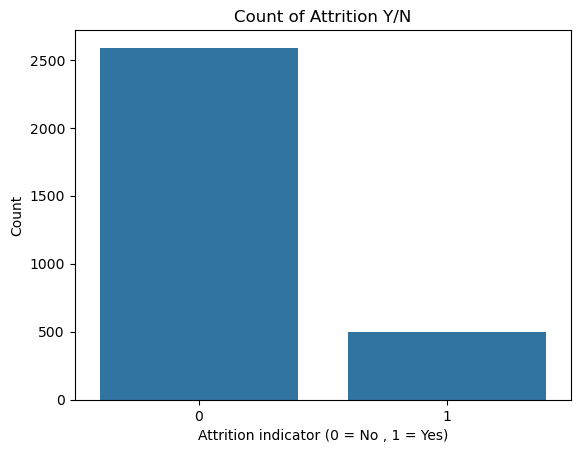

In [11]:
sns.countplot(data = attrition_train, x = 'Attrition_lab')
plt.xlabel('Attrition indicator (0 = No , 1 = Yes)')
plt.ylabel('Count')
plt.title('Count of Attrition Y/N')
plt.show()

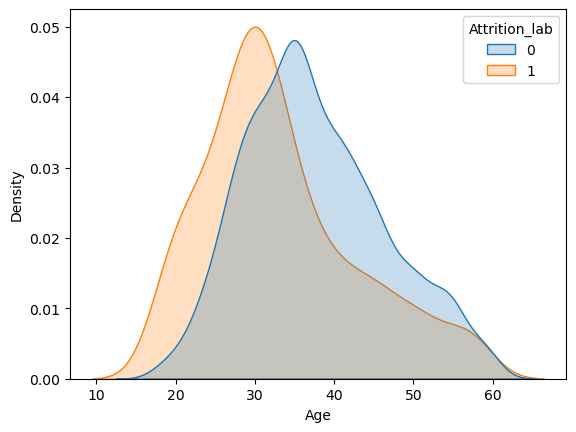

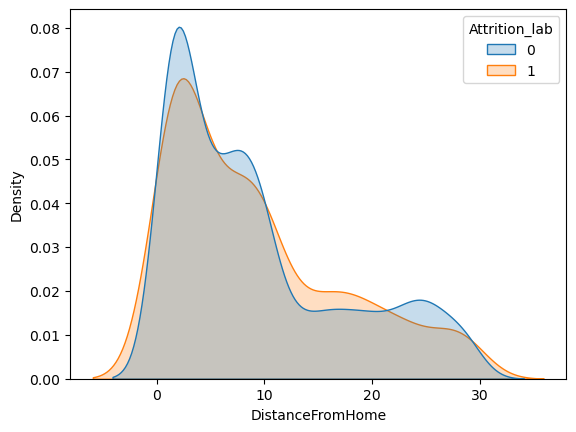

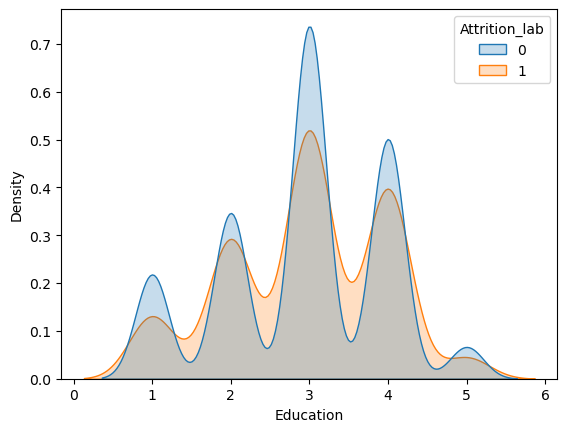

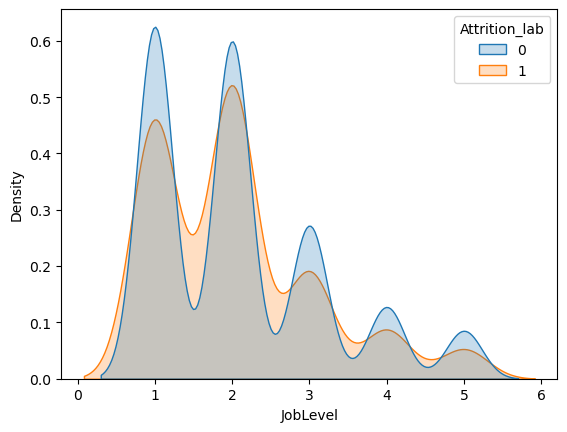

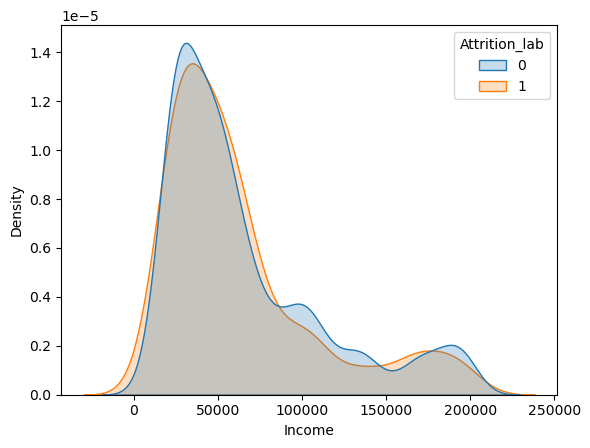

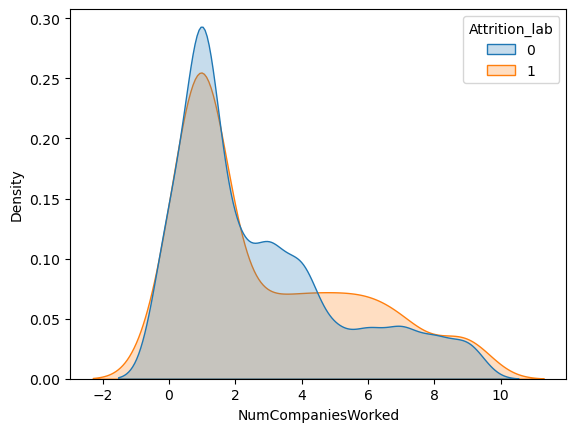

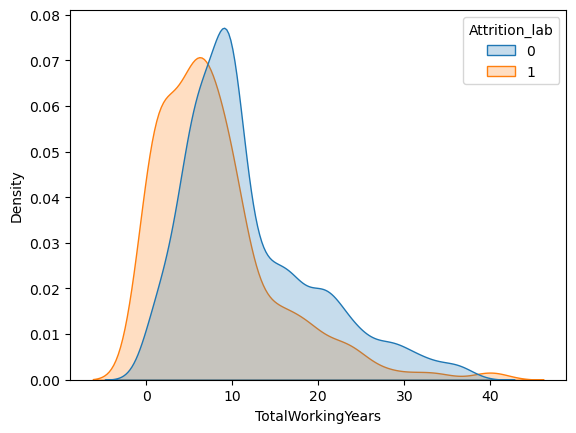

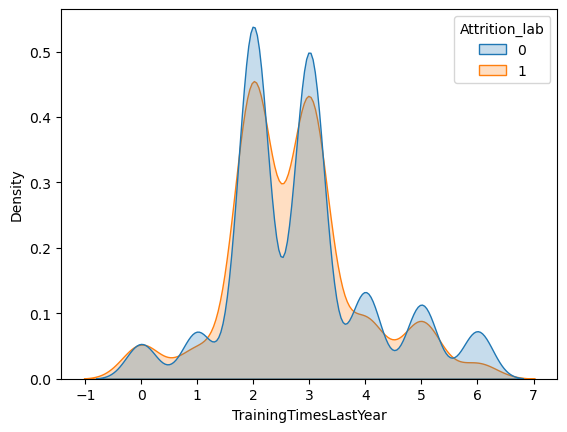

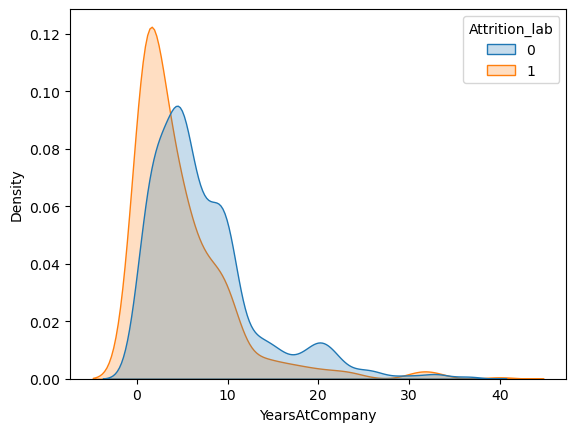

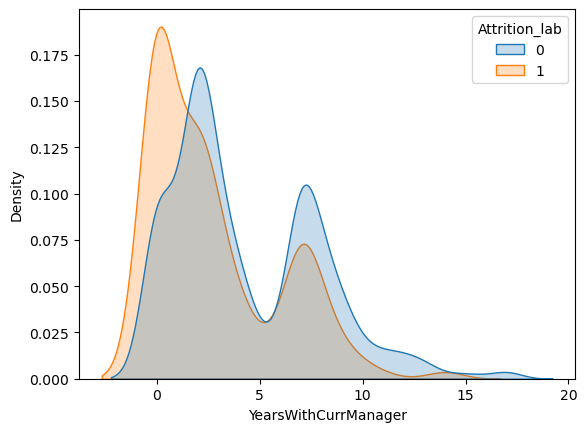

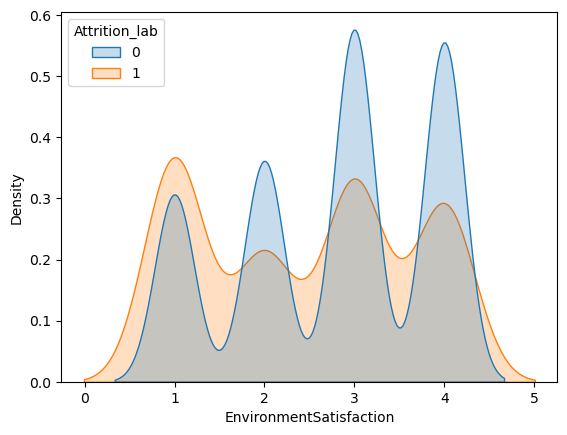

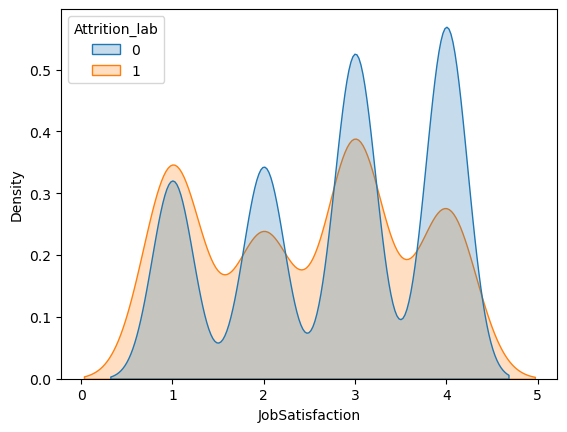

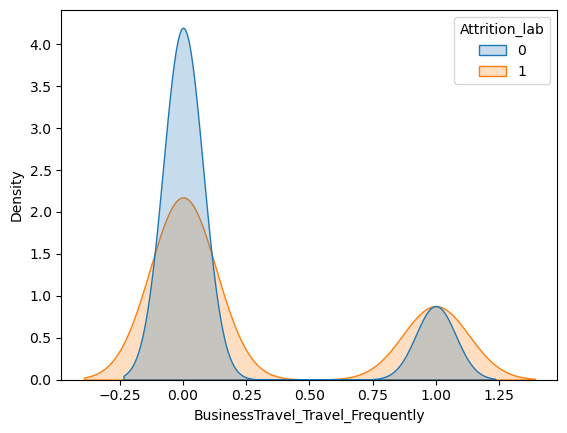

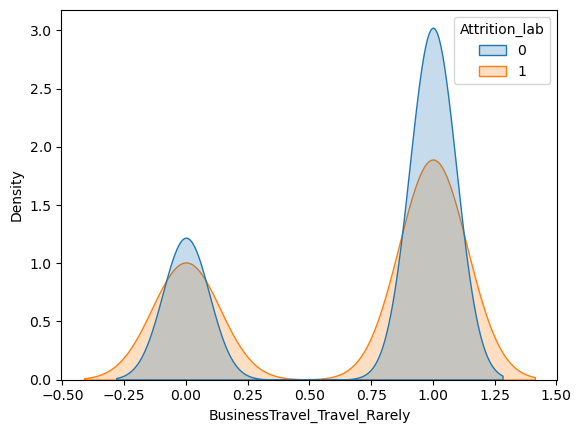

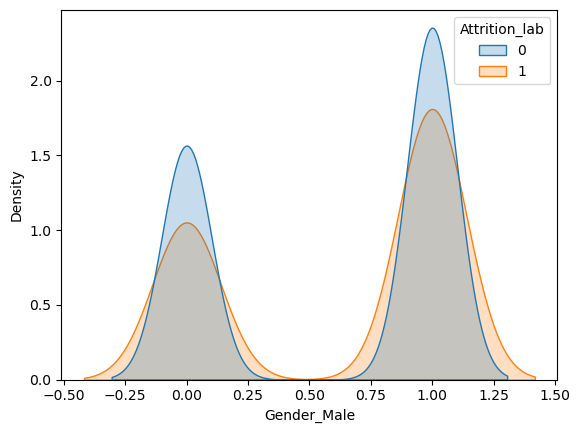

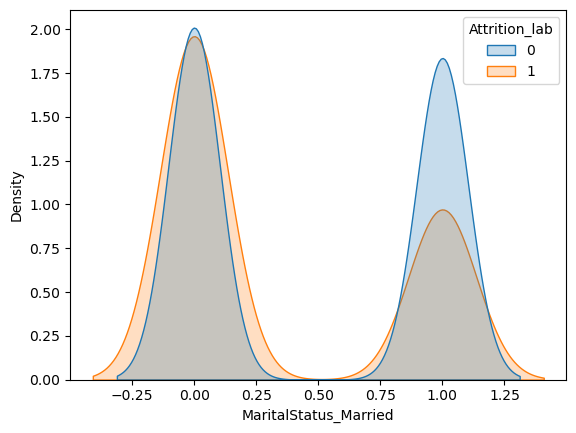

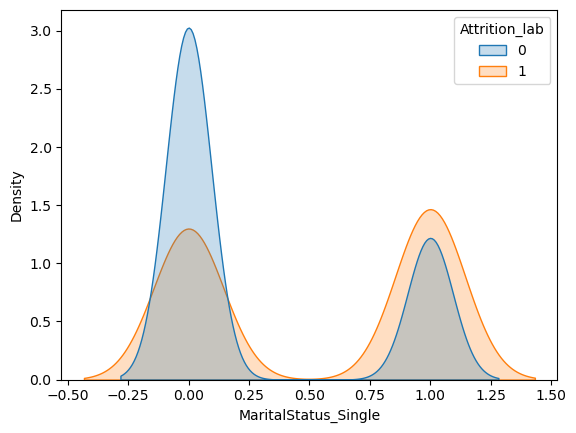

In [ ]:
all_features = ['Age', 'DistanceFromHome', 'Education',
'JobLevel', 'Income', 'NumCompaniesWorked','TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany',
'YearsWithCurrManager', 'EnvironmentSatisfaction', 'JobSatisfaction', 'BusinessTravel_Travel_Frequently',
'BusinessTravel_Travel_Rarely', 'Gender_Male', 'MaritalStatus_Married', 'MaritalStatus_Single']

for i in all_features:
    sns.kdeplot(
        data = attrition_train,
        x = i,
        hue = 'Attrition_lab',
        fill = True,
        common_norm = False
    )   
    plt.show()

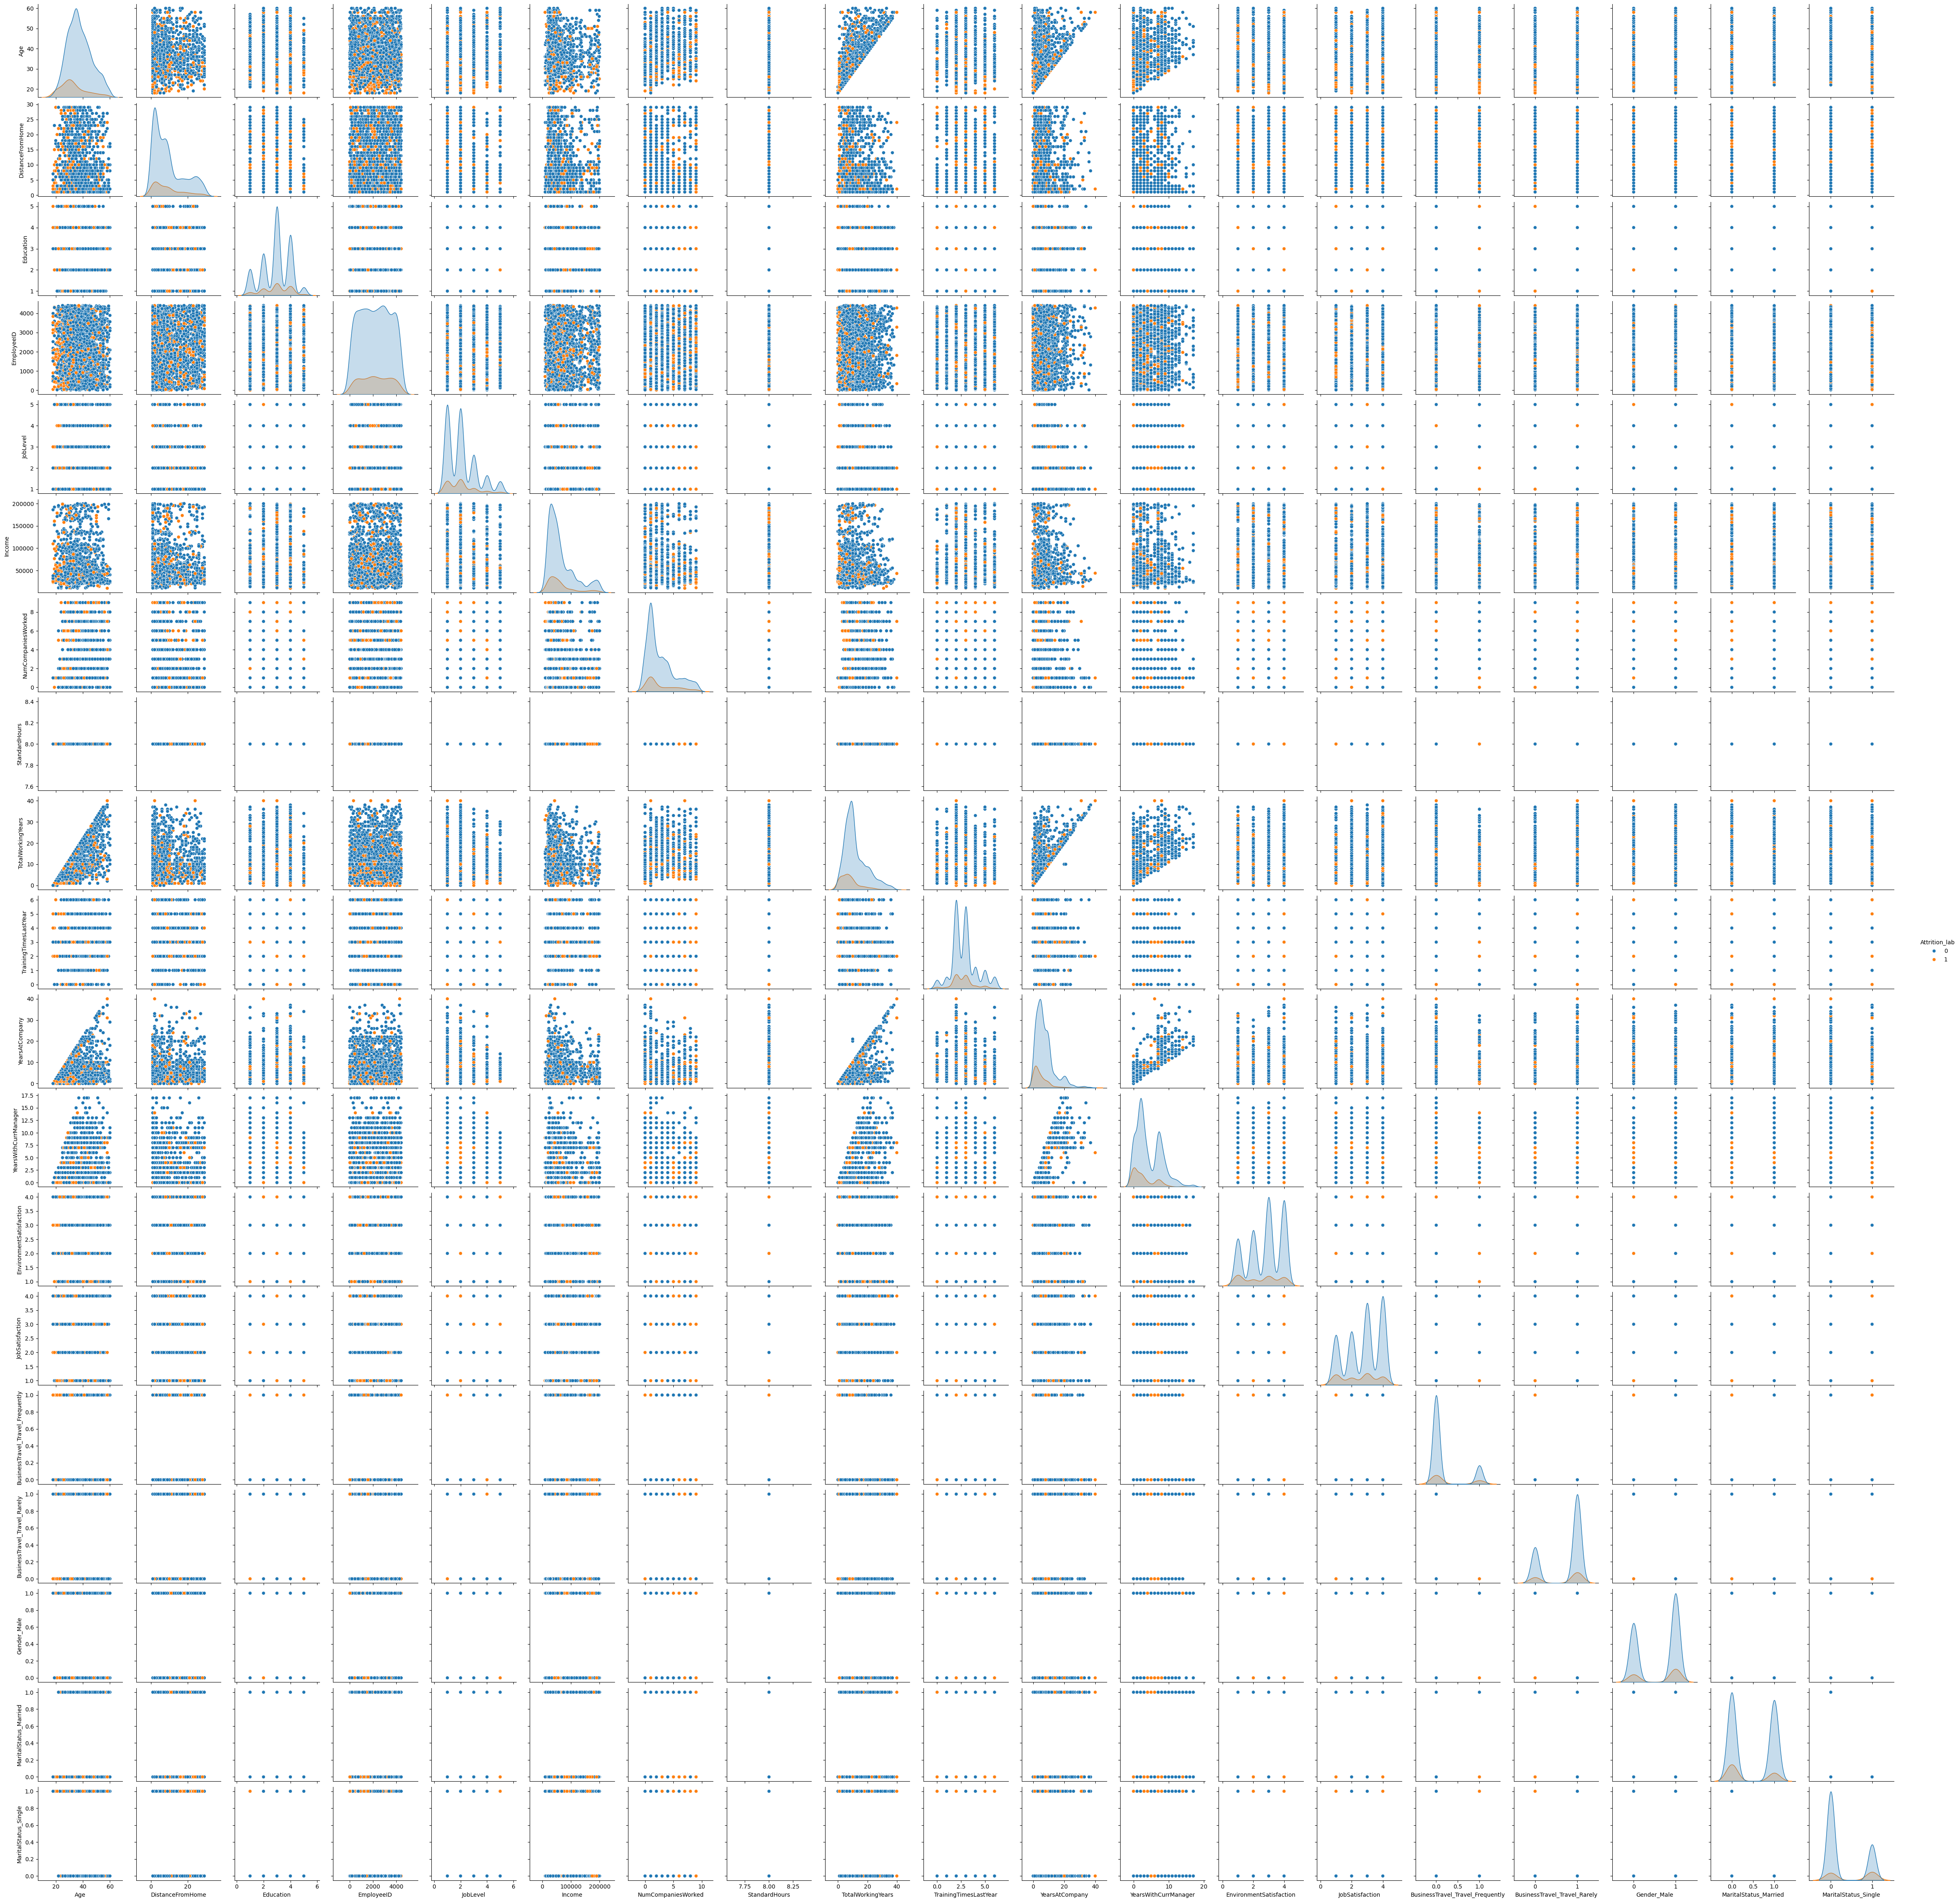

In [23]:
sns.pairplot(
    attrition_train,
    hue ='Attrition_lab',
    diag_kind = 'kde'
)
plt.show()

#### Based on the above countplot and the density plots we can see that the dataset is highly imbalanced
- will need to rebalance the dataset (downsample)

---

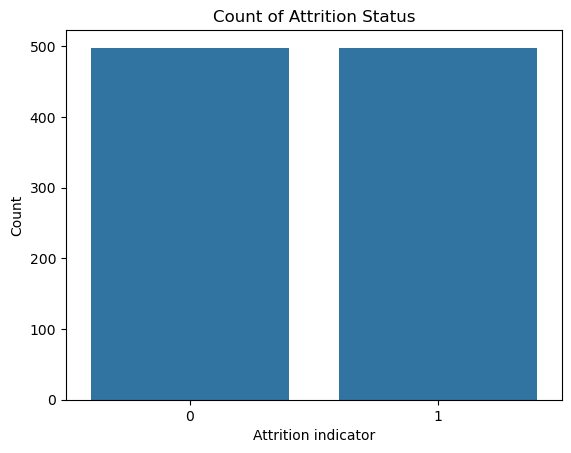

In [24]:
# Class imbalance: downsample the negative class; keep all positives
# + equal number of negatives
pos_idx = attrition_train.index[attrition_train["Attrition_lab"] == 1]
neg_idx = attrition_train.index[attrition_train["Attrition_lab"] == 0]

keep_neg = np.random.choice(neg_idx, size=len(pos_idx), replace=False)
keep_idx = np.concatenate([pos_idx, keep_neg])

attrition_train_bal = attrition_train.loc[keep_idx].copy()

# Quick look after balancing
sns.countplot(data = attrition_train_bal, x="Attrition_lab")
plt.xlabel("Attrition indicator")
plt.ylabel("Count")
plt.title("Count of Attrition Status")
plt.show()

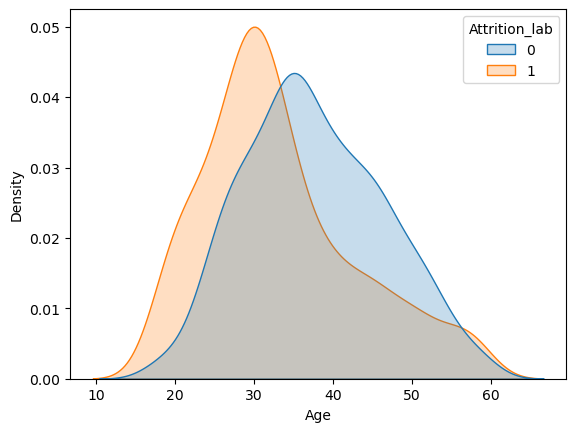

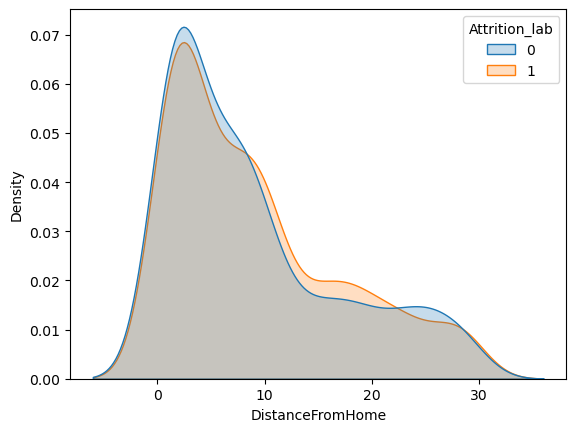

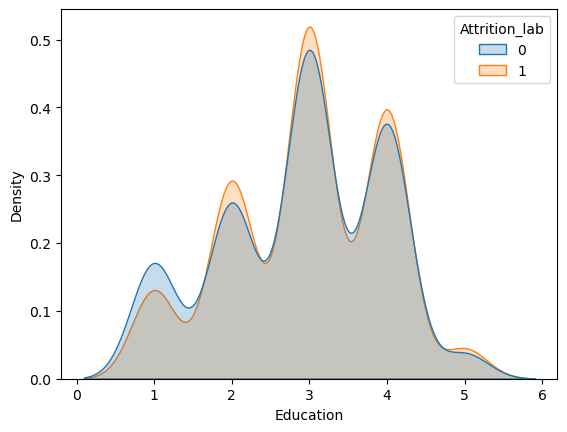

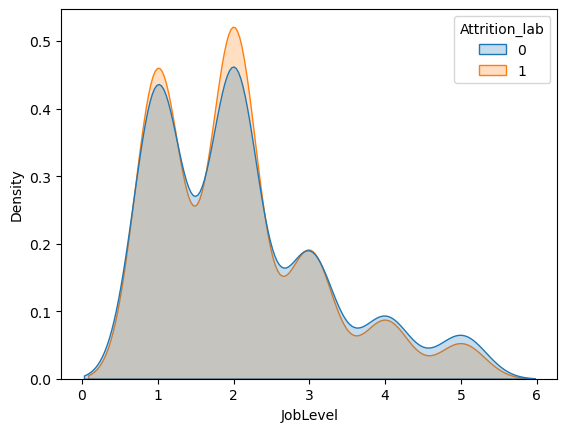

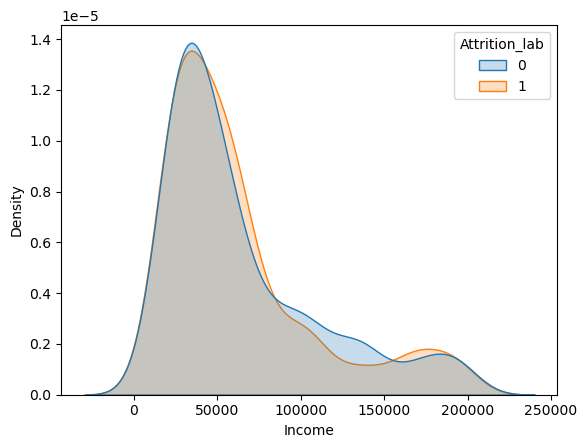

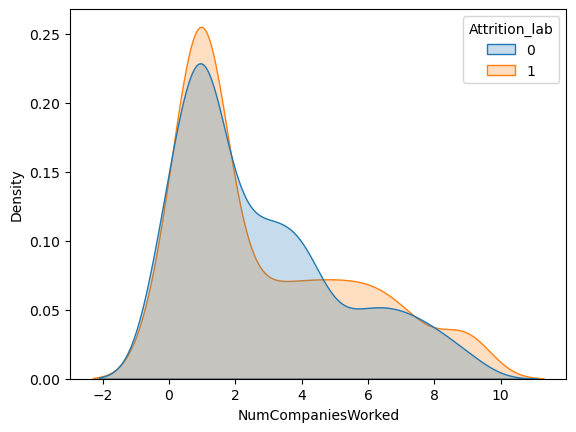

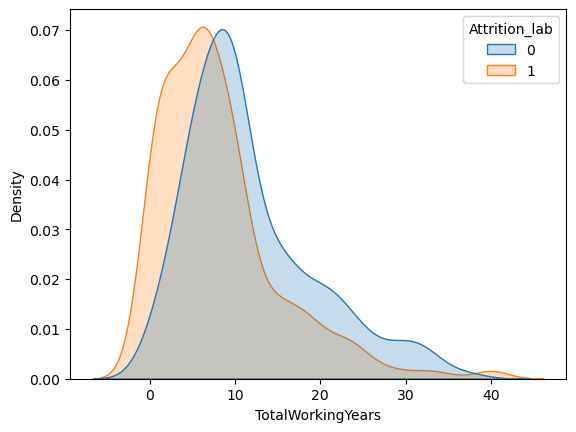

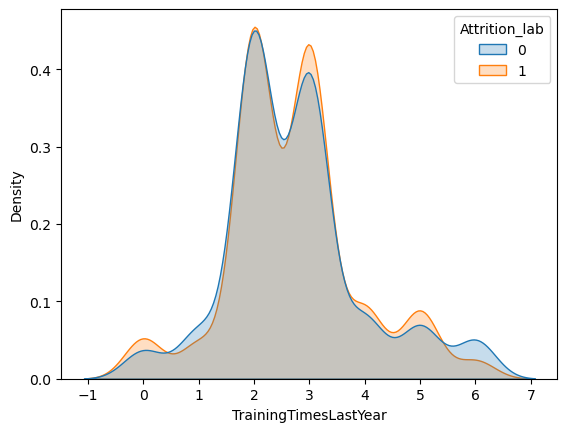

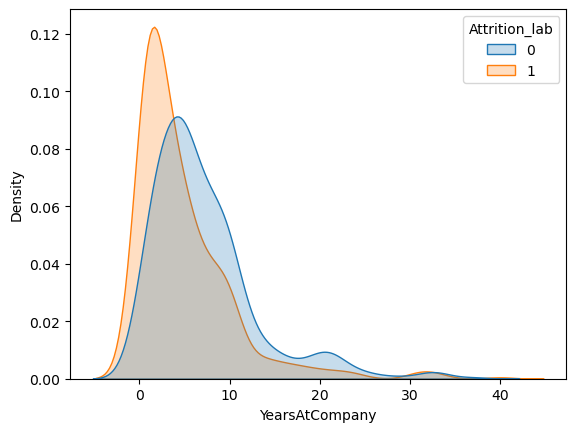

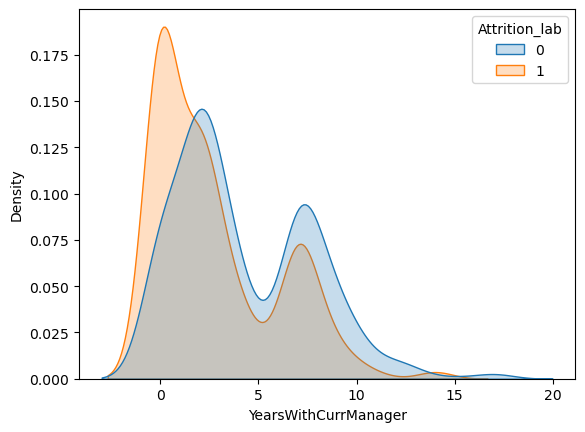

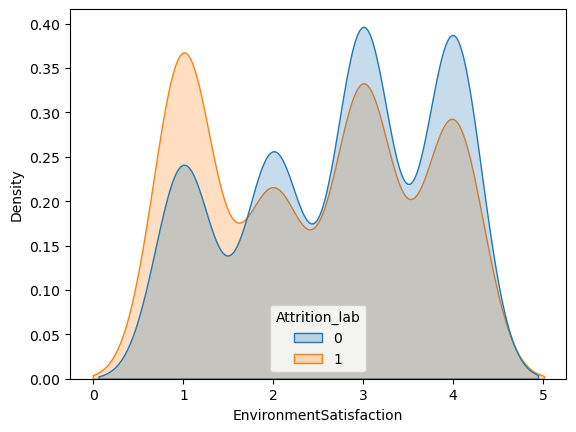

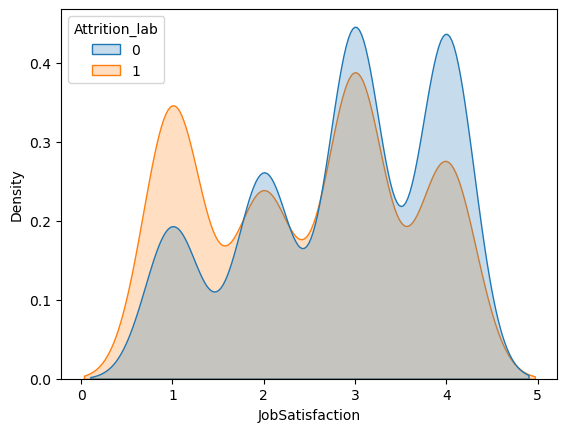

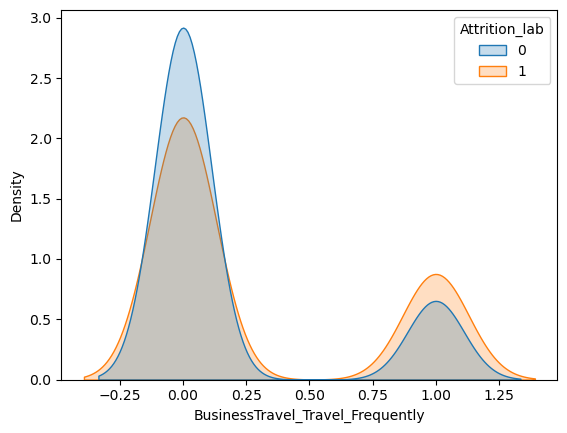

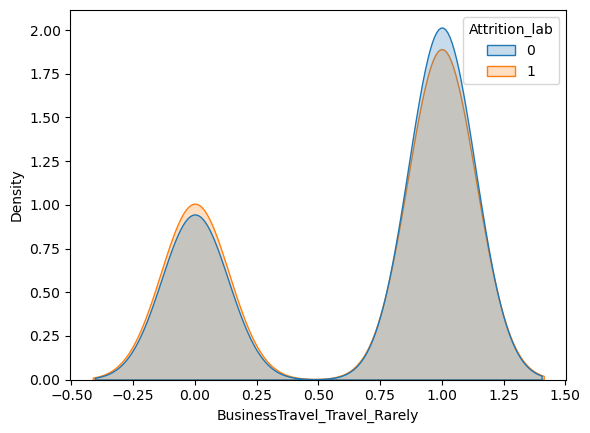

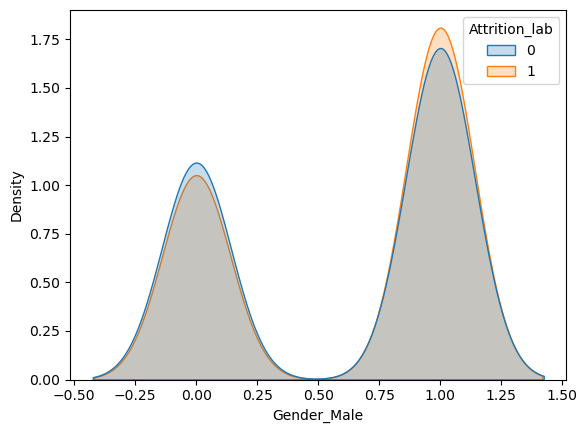

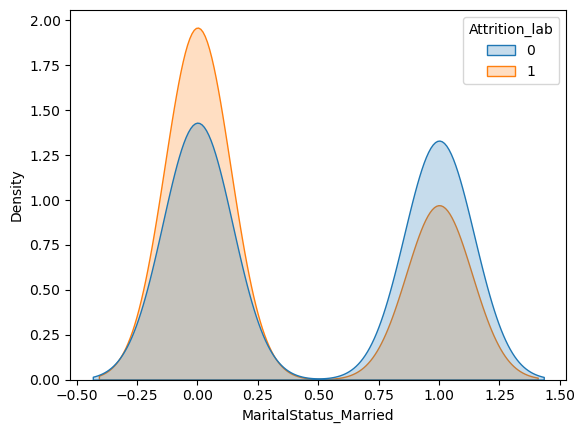

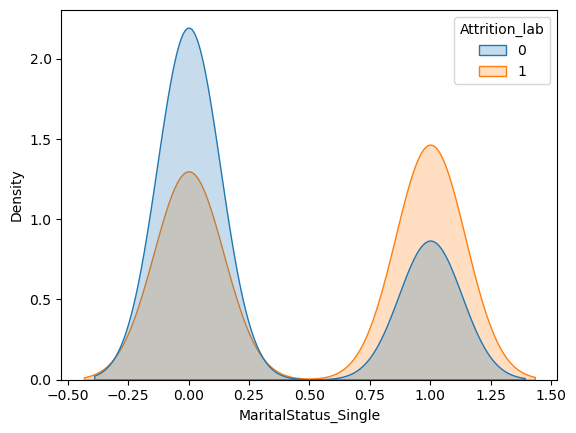

In [25]:
all_features = ['Age', 'DistanceFromHome', 'Education',
'JobLevel', 'Income', 'NumCompaniesWorked','TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany',
'YearsWithCurrManager', 'EnvironmentSatisfaction', 'JobSatisfaction', 'BusinessTravel_Travel_Frequently',
'BusinessTravel_Travel_Rarely', 'Gender_Male', 'MaritalStatus_Married', 'MaritalStatus_Single']

for i in all_features:
    sns.kdeplot(
        data = attrition_train_bal,
        x = i,
        hue = 'Attrition_lab',
        fill = True,
        common_norm = False
    )   
    plt.show()

---

#### Q2 Model Comparison - Choose four variables from the list provided (e.g., `Age`, `Gender`, `JobSatisfaction`, `Income`) and use them to create logistic regression models with the following combinations:
- Model 1: A one-variable model with `Age`.
- Model 2: A two-variable model with `Age` and `Gender`
- Model 3: A three-variable model with `Age`, `Gender`, and `JobSatisfaction`.
- Model 4: An interaction model involving `Age`, `Gender`, `JobSatisfaction`, `Income`, and `Gender:Income`. 
- Compare the validation-set performance of these models using the following metrics: AIC, AUC, Precision & Recall (use p = 0.5 as cutoff). Include tables summarizing the results. 
 Create a graph to visually represent the comparison of the models based on the selected metrics. 

#### the first step is to define the features needed for this model

In [68]:
model_1_features = ['Age']
model_2_features = ['Age', 'Gender_Male']
model_3_features = ['Age' , 'Gender_Male' , 'JobSatisfaction']

## need to create a new column for Gender:Income (need to do this for both our balanced train set and our X_test_encoded)

attrition_train_bal['Gender:Income'] = attrition_train_bal['Income'] * attrition_train_bal['Gender_Male']
attrition_train['Gender:Income'] = attrition_train['Income'] * attrition_train['Gender_Male']
attrition_test['Gender:Income'] = attrition_test['Income'] * attrition_test['Gender_Male']

model_4_features = ['Age' , 'Gender_Male' , 'JobSatisfaction' , 'Income' , 'Gender:Income' ]

#### additionally create a predictor column (drop the employee id column , attrition , and work hours columns)

In [29]:
predictors = attrition_train_bal.columns.tolist()
### need to remove Attrition, EmployeeID , StandardHours , Attrition_lab
predictors.remove('Attrition_lab')
predictors.remove('Attrition')
predictors.remove('EmployeeID')
predictors.remove('StandardHours')
predictors


['Age',
 'DistanceFromHome',
 'Education',
 'JobLevel',
 'Income',
 'NumCompaniesWorked',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'YearsAtCompany',
 'YearsWithCurrManager',
 'EnvironmentSatisfaction',
 'JobSatisfaction',
 'BusinessTravel_Travel_Frequently',
 'BusinessTravel_Travel_Rarely',
 'Gender_Male',
 'MaritalStatus_Married',
 'MaritalStatus_Single',
 'Gender:Income']

#### Create the models 
- first we will create the models 
- Also will create a model with all the predictors

---

#### Create a function to run each base model

In [36]:
def log_reg_summary(df, response, predictors): 
    model = sm.Logit(df[response], sm.add_constant(df[predictors])).fit()
    print(f"\n=== f1 summary ({len(predictors)} features)===")
    print(model.summary())
    return model


---

#### Model 1

In [74]:
print('Unbalanced')
model1_unbalanced = log_reg_summary(attrition_train , 'Attrition_lab' , model_1_features)
print('=================================================================================')
print('=================================================================================')
print('=================================================================================')
print('Balanced')
model1 = log_reg_summary(attrition_train_bal , 'Attrition_lab' , model_1_features)


Unbalanced
Optimization terminated successfully.
         Current function value: 0.424761
         Iterations 6

=== f1 summary (1 features)===
                           Logit Regression Results                           
Dep. Variable:          Attrition_lab   No. Observations:                 3087
Model:                          Logit   Df Residuals:                     3085
Method:                           MLE   Df Model:                            1
Date:                Sat, 29 Nov 2025   Pseudo R-squ.:                 0.03869
Time:                        13:39:46   Log-Likelihood:                -1311.2
converged:                       True   LL-Null:                       -1364.0
Covariance Type:            nonrobust   LLR p-value:                 9.299e-25
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4516      0.213      2.124      0.034       0.03

---

#### Model 2

In [75]:
print('Unbalanced')
model2_unbalanced = log_reg_summary(attrition_train , 'Attrition_lab' , model_2_features)
print('=================================================================================')
print('=================================================================================')
print('=================================================================================')
print('Balanced')
model2 = log_reg_summary(attrition_train_bal , 'Attrition_lab' , model_2_features)


Unbalanced
Optimization terminated successfully.
         Current function value: 0.424663
         Iterations 6

=== f1 summary (2 features)===
                           Logit Regression Results                           
Dep. Variable:          Attrition_lab   No. Observations:                 3087
Model:                          Logit   Df Residuals:                     3084
Method:                           MLE   Df Model:                            2
Date:                Sat, 29 Nov 2025   Pseudo R-squ.:                 0.03891
Time:                        13:39:49   Log-Likelihood:                -1310.9
converged:                       True   LL-Null:                       -1364.0
Covariance Type:            nonrobust   LLR p-value:                 8.931e-24
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.3929      0.226      1.742      0.082      -0

----

#### Model 3

In [76]:
print('Unbalanced')
model3_unbalanced = log_reg_summary(attrition_train , 'Attrition_lab' , model_3_features)
print('=================================================================================')
print('=================================================================================')
print('=================================================================================')
print('Balanced')
model3 = log_reg_summary(attrition_train_bal , 'Attrition_lab' , model_3_features)


Unbalanced
Optimization terminated successfully.
         Current function value: 0.419865
         Iterations 6

=== f1 summary (3 features)===
                           Logit Regression Results                           
Dep. Variable:          Attrition_lab   No. Observations:                 3087
Model:                          Logit   Df Residuals:                     3083
Method:                           MLE   Df Model:                            3
Date:                Sat, 29 Nov 2025   Pseudo R-squ.:                 0.04977
Time:                        13:39:52   Log-Likelihood:                -1296.1
converged:                       True   LL-Null:                       -1364.0
Covariance Type:            nonrobust   LLR p-value:                 3.093e-29
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.0431      0.256      4.075      0

---

#### Model 4

In [69]:
print('Unbalanced')
model4_unbalanced = log_reg_summary(attrition_train , 'Attrition_lab' , model_4_features)
print('=================================================================================')
print('=================================================================================')
print('=================================================================================')
print('Balanced')
model4 = log_reg_summary(attrition_train_bal , 'Attrition_lab' , model_4_features)


Unbalanced
Optimization terminated successfully.
         Current function value: 0.419425
         Iterations 6

=== f1 summary (5 features)===
                           Logit Regression Results                           
Dep. Variable:          Attrition_lab   No. Observations:                 3087
Model:                          Logit   Df Residuals:                     3081
Method:                           MLE   Df Model:                            5
Date:                Sat, 29 Nov 2025   Pseudo R-squ.:                 0.05076
Time:                        13:36:55   Log-Likelihood:                -1294.8
converged:                       True   LL-Null:                       -1364.0
Covariance Type:            nonrobust   LLR p-value:                 3.760e-28
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.2014      0.284      4.235      0

---

#### All predictors

In [70]:
print('Unbalanced')
model_all_unbalanced = log_reg_summary(attrition_train , 'Attrition_lab' , predictors)
print('=================================================================================')
print('=================================================================================')
print('=================================================================================')
print('Balanced')
model_all = log_reg_summary(attrition_train_bal , 'Attrition_lab' , predictors)

Unbalanced
Optimization terminated successfully.
         Current function value: 0.376104
         Iterations 7

=== f1 summary (18 features)===
                           Logit Regression Results                           
Dep. Variable:          Attrition_lab   No. Observations:                 3087
Model:                          Logit   Df Residuals:                     3068
Method:                           MLE   Df Model:                           18
Date:                Sat, 29 Nov 2025   Pseudo R-squ.:                  0.1488
Time:                        13:37:58   Log-Likelihood:                -1161.0
converged:                       True   LL-Null:                       -1364.0
Covariance Type:            nonrobust   LLR p-value:                 5.259e-75
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const               

---

# VIF Table to explore multicolinearity
#### now that we have gotten the base models, we can produce a VIF table to explore the VIF values for each variable

In [77]:
def vif_table(model):
    X = model.model.exog
    names = model.model.exog_names
    vif_values = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
    return pd.DataFrame({"variable": names, "VIF": vif_values})

In [78]:
### helper function to print results of all the models
def print_vif(f1):
    vif_df = vif_table(f1)
    return vif_df

---

#### Model 1

In [83]:
print('Unbalanced')
print_vif(model1_unbalanced)

Unbalanced


variable        VIF
0    const  17.295005
1      Age   1.000000

In [84]:
print('Balanced')
print_vif(model1)

Balanced


variable       VIF
0    const  14.70702
1      Age   1.00000

---

#### Model 2

In [85]:
print('Unbalanced')
print_vif(model2_unbalanced)

Unbalanced


variable        VIF
0        const  19.387184
1          Age   1.002585
2  Gender_Male   1.002585

In [86]:
print('Balanced')
print_vif(model2)

Balanced


variable        VIF
0        const  16.876244
1          Age   1.002855
2  Gender_Male   1.002855

---

### Model 3

In [87]:
print('Unbalanced')
print_vif(model3_unbalanced)

Unbalanced


variable        VIF
0            const  25.359207
1              Age   1.002587
2      Gender_Male   1.002829
3  JobSatisfaction   1.000243

In [88]:
print('Balanced')
print_vif(model3)

Balanced


variable        VIF
0            const  21.878804
1              Age   1.006821
2      Gender_Male   1.003552
3  JobSatisfaction   1.004842

---

### Model 4

In [89]:
print('Unbalanced')
print_vif(model4_unbalanced)


Unbalanced


variable        VIF
0            const  30.202423
1              Age   1.004074
2      Gender_Male   2.879654
3  JobSatisfaction   1.000432
4           Income   2.519779
5    Gender:Income   4.413857

In [90]:
print('Balanced')
print_vif(model4)

Balanced


variable        VIF
0            const  27.003368
1              Age   1.008109
2      Gender_Male   2.898703
3  JobSatisfaction   1.005279
4           Income   2.771043
5    Gender:Income   4.756820

----

#### All Features Model

In [91]:
print('Unbalanced')
print_vif(model_all_unbalanced)


Unbalanced


variable        VIF
0                              const  76.115910
1                                Age   2.024282
2                   DistanceFromHome   1.012427
3                          Education   1.009536
4                           JobLevel   1.013928
5                             Income   2.550961
6                 NumCompaniesWorked   1.254810
7                  TotalWorkingYears   3.050359
8              TrainingTimesLastYear   1.015776
9                     YearsAtCompany   3.395110
10              YearsWithCurrManager   2.459867
11           EnvironmentSatisfaction   1.008057
12                   JobSatisfaction   1.009160
13  BusinessTravel_Travel_Frequently   2.308968
14      BusinessTravel_Travel_Rarely   2.317650
15                       Gender_Male   2.903565
16             MaritalStatus_Married   1.686831
17              MaritalStatus_Single   1.697136
18                     Gender:Income   4.433745

In [92]:
print('Balanced')
print_vif(model_all)

Balanced


variable        VIF
0                              const  73.066207
1                                Age   2.070055
2                   DistanceFromHome   1.037178
3                          Education   1.021891
4                           JobLevel   1.033303
5                             Income   2.840191
6                 NumCompaniesWorked   1.267564
7                  TotalWorkingYears   3.215623
8              TrainingTimesLastYear   1.039825
9                     YearsAtCompany   3.688796
10              YearsWithCurrManager   2.584106
11           EnvironmentSatisfaction   1.019229
12                   JobSatisfaction   1.028697
13  BusinessTravel_Travel_Frequently   2.684813
14      BusinessTravel_Travel_Rarely   2.741579
15                       Gender_Male   2.946242
16             MaritalStatus_Married   1.934749
17              MaritalStatus_Single   1.955403
18                     Gender:Income   4.861400

---

#### ROC / AUC / Precision / Recall
- test balanced/unbalanced trained dataset

#### Create a helper function to evaulate the models

In [58]:
def evaulate_model(df , model , response, predictors, score):
    train_probs = model.predict(sm.add_constant(df[predictors]))
    train_pred_class = (train_probs >= score).astype(int)
    cm_train = confusion_matrix(df[response] , train_pred_class)
    precision_train = precision_score(df[response] , train_pred_class)
    recall_train = recall_score(df[response] , train_pred_class)
    print("\nIn-sample confusion matrix (threshold = 0.5):")
    dataframe = pd.DataFrame(
        cm_train,
        index=["Actual 0", "Actual 1"],
        columns=["Pred 0", "Pred 1"]
    )
    print(f"\nPrecision (train): {precision_train:.3f}")
    print(f"Recall (train):    {recall_train:.3f}")
    return dataframe

---

#### Model 1 Comparision

In [94]:
print('Unbalanced')
evaulate_model(attrition_train , model1_unbalanced , 'Attrition_lab',
               model_1_features , 0.5)

Unbalanced

In-sample confusion matrix (threshold = 0.5):

Precision (train): 0.000
Recall (train):    0.000


c:\Users\liula\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Pred 0  Pred 1
Actual 0    2589       0
Actual 1     498       0

In [93]:
print('Balanced')
evaulate_model(attrition_train_bal , model1 , 'Attrition_lab',
               model_1_features , 0.5)

Balanced

In-sample confusion matrix (threshold = 0.5):

Precision (train): 0.609
Recall (train):    0.687


Pred 0  Pred 1
Actual 0     278     220
Actual 1     156     342

---

#### Model 2 Comparision

In [95]:
print('Unbalanced')
evaulate_model(attrition_train , model2_unbalanced , 'Attrition_lab',
               model_2_features , 0.5)

Unbalanced

In-sample confusion matrix (threshold = 0.5):

Precision (train): 0.000
Recall (train):    0.000


c:\Users\liula\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Pred 0  Pred 1
Actual 0    2589       0
Actual 1     498       0

In [96]:
print('Balanced')
evaulate_model(attrition_train_bal , model2 , 'Attrition_lab',
               model_2_features , 0.5)

Balanced

In-sample confusion matrix (threshold = 0.5):

Precision (train): 0.618
Recall (train):    0.675


Pred 0  Pred 1
Actual 0     290     208
Actual 1     162     336

---

#### Model 3 Comparision

In [101]:
print('Unbalanced')
evaulate_model(attrition_train , model3_unbalanced , 'Attrition_lab',
               model_3_features , 0.5)

Unbalanced

In-sample confusion matrix (threshold = 0.5):

Precision (train): 0.000
Recall (train):    0.000


c:\Users\liula\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Pred 0  Pred 1
Actual 0    2589       0
Actual 1     498       0

In [102]:
print('Balanced')
evaulate_model(attrition_train_bal , model3 , 'Attrition_lab',
               model_3_features , 0.5)

Balanced

In-sample confusion matrix (threshold = 0.5):

Precision (train): 0.627
Recall (train):    0.639


Pred 0  Pred 1
Actual 0     309     189
Actual 1     180     318

---

#### Model 4 Comparision

In [99]:
print('Unbalanced')
evaulate_model(attrition_train , model4_unbalanced , 'Attrition_lab',
               model_4_features , 0.5)

Unbalanced

In-sample confusion matrix (threshold = 0.5):

Precision (train): 0.000
Recall (train):    0.000


c:\Users\liula\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Pred 0  Pred 1
Actual 0    2589       0
Actual 1     498       0

In [100]:
print('Balanced')
evaulate_model(attrition_train_bal , model4 , 'Attrition_lab',
               model_4_features , 0.5)

Balanced

In-sample confusion matrix (threshold = 0.5):

Precision (train): 0.615
Recall (train):    0.629


Pred 0  Pred 1
Actual 0     302     196
Actual 1     185     313

---

#### All Predictors Model Comparision

In [97]:
print('Unbalanced')
evaulate_model(attrition_train , model_all_unbalanced , 'Attrition_lab',
               predictors , 0.5)

Unbalanced

In-sample confusion matrix (threshold = 0.5):

Precision (train): 0.767
Recall (train):    0.159


Pred 0  Pred 1
Actual 0    2565      24
Actual 1     419      79

In [98]:
print('Balanced')
evaulate_model(attrition_train_bal , model_all , 'Attrition_lab',
               predictors , 0.5)

Balanced

In-sample confusion matrix (threshold = 0.5):

Precision (train): 0.690
Recall (train):    0.715


Pred 0  Pred 1
Actual 0     338     160
Actual 1     142     356

---

### create ROC and AUC Curve 

In [105]:
def evaluate_model_plot(df, model, response, predictors, score=0.5, model_name='f1', dataset_name='train'):
    train_probs = model.predict(sm.add_constant(df[predictors]))
    train_pred_class = (train_probs >= score).astype(int)
    cm_train = confusion_matrix(df[response], train_pred_class)
    precision_train = precision_score(df[response], train_pred_class)
    recall_train = recall_score(df[response], train_pred_class)
    print("\nIn-sample confusion matrix (threshold = 0.5):")
    dataframe = pd.DataFrame(
        cm_train,
        index=["Actual 0", "Actual 1"],
        columns=["Pred 0", "Pred 1"]
    )
    print(f"\nPrecision (train): {precision_train:.3f}")
    print(f"Recall (train):    {recall_train:.3f}")
    
    # ROC & AUC
    fpr, tpr, _ = roc_curve(df[response], train_probs)
    auc_f1 = roc_auc_score(df[response], train_probs)
    
    plt.plot(fpr, tpr, label=f"{model_name} ROC (AUC={auc_f1:.3f})")
    plt.plot([0,1],[0,1], "k--")
    plt.legend(); plt.title(f"{dataset_name} ROC"); plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.show()
    print(f"AUC ({model_name}, {dataset_name}): {auc_f1:.3f}")
    
    return dataframe, auc_f1


In-sample confusion matrix (threshold = 0.5):

Precision (train): 0.000
Recall (train):    0.000


c:\Users\liula\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


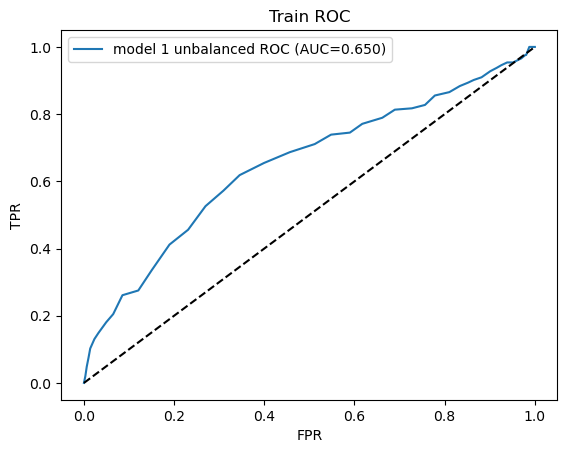

AUC (model 1 unbalanced, Train): 0.650


In [125]:
cm_df_1_un, auc_f1_1_un = evaluate_model_plot(attrition_train, model1_unbalanced, 'Attrition_lab',
    model_1_features  , score=0.5, model_name='model 1 unbalanced', dataset_name='Train')


In-sample confusion matrix (threshold = 0.5):

Precision (train): 0.609
Recall (train):    0.687


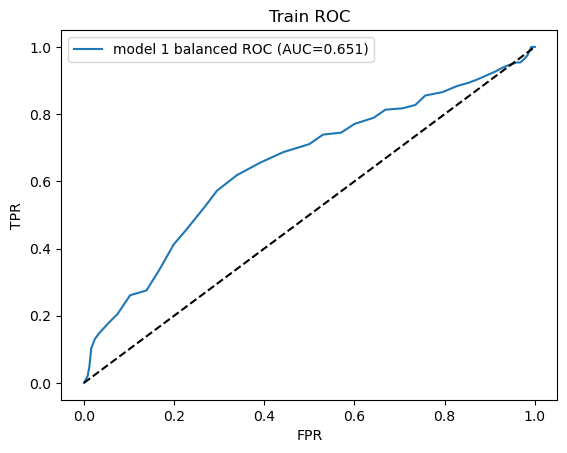

AUC (model 1 balanced, Train): 0.651


In [126]:
cm_df_1_bal, auc_f1_1_bal = evaluate_model_plot(attrition_train_bal, model1, 'Attrition_lab',
    model_1_features  , score=0.5, model_name='model 1 balanced', dataset_name='Train')

---


In-sample confusion matrix (threshold = 0.5):

Precision (train): 0.000
Recall (train):    0.000


c:\Users\liula\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


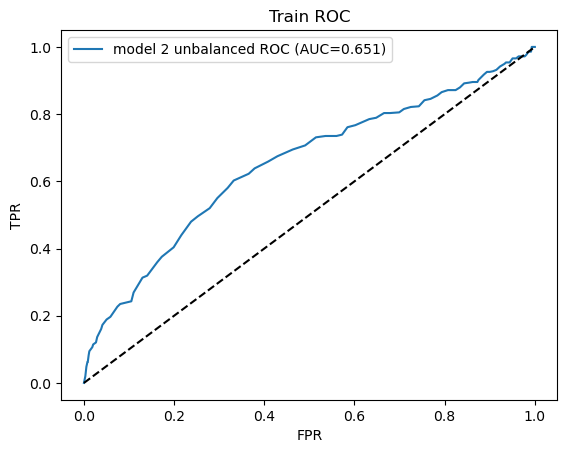

AUC (model 2 unbalanced, Train): 0.651


In [127]:
cm_df_2_un, auc_f1_2_un = evaluate_model_plot(attrition_train, model2_unbalanced, 'Attrition_lab',
    model_2_features  , score=0.5, model_name='model 2 unbalanced', dataset_name='Train')


In-sample confusion matrix (threshold = 0.5):

Precision (train): 0.618
Recall (train):    0.675


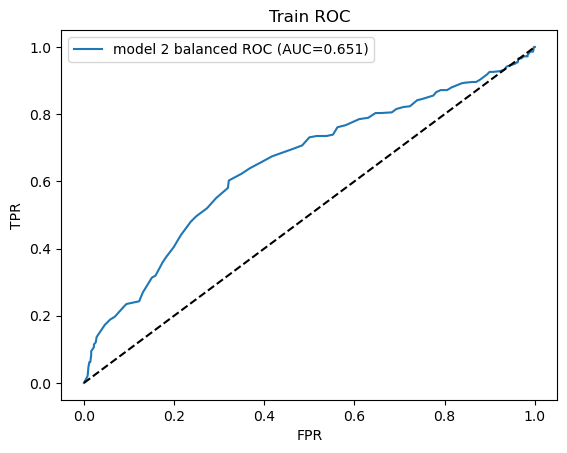

AUC (model 2 balanced, Train): 0.651


In [124]:
cm_df_2_bal, auc_f1_2_bal = evaluate_model_plot(attrition_train_bal, model2, 'Attrition_lab',
    model_2_features  , score=0.5, model_name='model 2 balanced', dataset_name='Train')

---


In-sample confusion matrix (threshold = 0.5):

Precision (train): 0.000
Recall (train):    0.000


c:\Users\liula\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


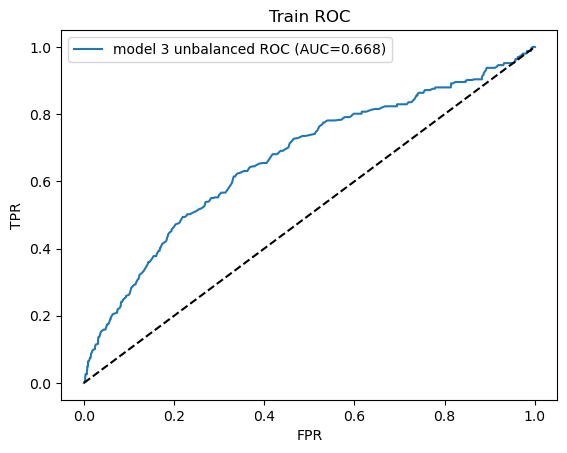

AUC (model 3 unbalanced, Train): 0.668


In [123]:
cm_df_3_un, auc_f1_3_un = evaluate_model_plot(attrition_train, model3_unbalanced, 'Attrition_lab',
    model_3_features  , score=0.5, model_name='model 3 unbalanced', dataset_name='Train')


In-sample confusion matrix (threshold = 0.5):

Precision (train): 0.627
Recall (train):    0.639


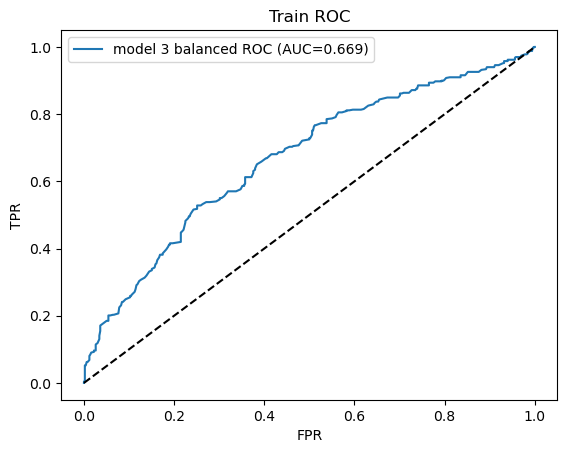

AUC (model 3 balanced, Train): 0.669


In [122]:
cm_df_3_bal, auc_f1_3_bal = evaluate_model_plot(attrition_train_bal, model3, 'Attrition_lab',
    model_3_features  , score=0.5, model_name='model 3 balanced', dataset_name='Train')

---


In-sample confusion matrix (threshold = 0.5):

Precision (train): 0.000
Recall (train):    0.000


c:\Users\liula\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


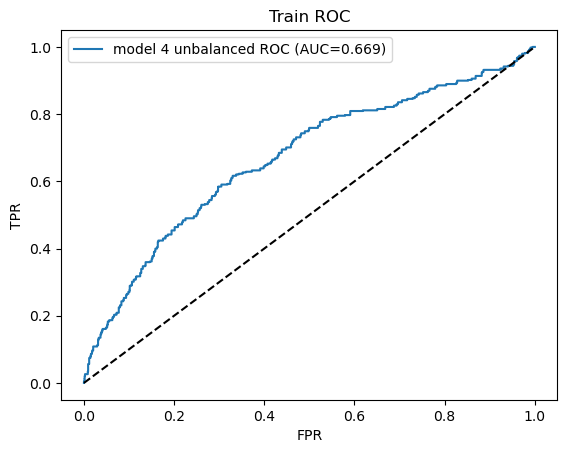

AUC (model 4 unbalanced, Train): 0.669


In [121]:
cm_df_4_un, auc_f1_4_un = evaluate_model_plot(attrition_train, model4_unbalanced, 'Attrition_lab',
    model_4_features  , score=0.5, model_name='model 4 unbalanced', dataset_name='Train')


In-sample confusion matrix (threshold = 0.5):

Precision (train): 0.615
Recall (train):    0.629


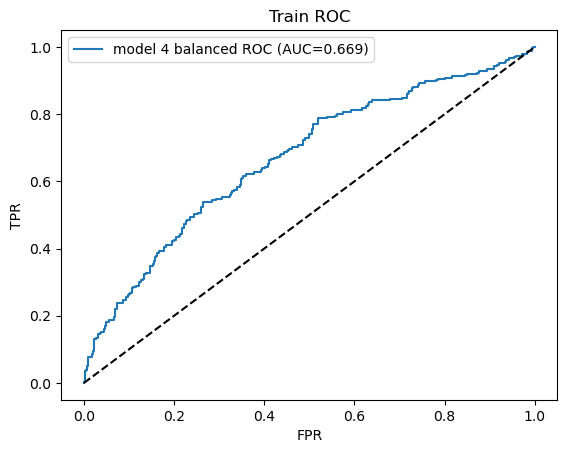

AUC (model 4 balanced, Train): 0.669


In [120]:
cm_df_4_bal, auc_f1_4_bal = evaluate_model_plot(attrition_train_bal, model4, 'Attrition_lab',
    model_4_features  , score=0.5, model_name='model 4 balanced', dataset_name='Train')

---


In-sample confusion matrix (threshold = 0.5):

Precision (train): 0.767
Recall (train):    0.159


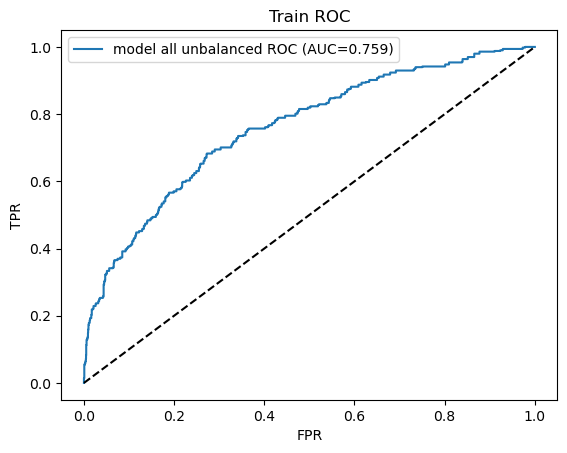

AUC (model all unbalanced, Train): 0.759


In [119]:
cm_df_all_un, auc_f1_all_un = evaluate_model_plot(attrition_train, model_all_unbalanced, 'Attrition_lab',
    predictors  , score=0.5, model_name='model all unbalanced', dataset_name='Train')


In-sample confusion matrix (threshold = 0.5):

Precision (train): 0.690
Recall (train):    0.715


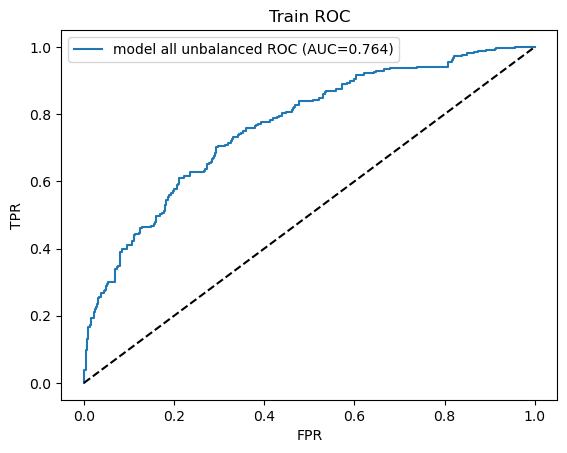

AUC (model all unbalanced, Train): 0.764


In [118]:
cm_df_all_bal, auc_f1_all_bal = evaluate_model_plot(attrition_train_bal, model_all, 'Attrition_lab',
    predictors  , score=0.5, model_name='model all unbalanced', dataset_name='Train')

---

# Question 3
#### Predictive Performance - Using the logistic regression models that you have developed, perform a prediction analysis for employee attrition. 
- For each of the four models, calculate the predicted probabilities of employee attrition for the test dataset.
- Calculate predicted probabilities for each model using the test dataset
- Create ROC curve objects for each model
- Create ROC curves for each model to evaluate their discriminatory power in predicting attrition.
- Plot ROC curves for all four models on one plot
- Compare the ROC curves and AUC. Discuss which model appears to be the most effective in distinguishing between employees with and without attrition.

---

#### Test set predictions and evaulations

In [130]:
test_probs1_un = model1_unbalanced.predict(sm.add_constant(attrition_test[model_1_features]))
test_probs1_bal = model1.predict(sm.add_constant(attrition_test[model_1_features]))
auc_test1_un = roc_auc_score(attrition_test["Attrition_lab"], test_probs1_un)
auc_test1_bal = roc_auc_score(attrition_test["Attrition_lab"], test_probs1_bal)
test_auc_df_1 = pd.DataFrame({
    "Model": ["model 1 unbalanced", "model 1 balanced"],
    "AUC": [auc_test1_un, auc_test1_bal]
})
test_auc_df_1

Model       AUC
0  model 1 unbalanced  0.595912
1    model 1 balanced  0.595912

In [131]:
test_probs2_un = model2_unbalanced.predict(sm.add_constant(attrition_test[model_2_features]))
test_probs2_bal = model2.predict(sm.add_constant(attrition_test[model_2_features]))
auc_test2_un = roc_auc_score(attrition_test["Attrition_lab"], test_probs2_un)
auc_test2_bal = roc_auc_score(attrition_test["Attrition_lab"], test_probs2_bal)
test_auc_df_2 = pd.DataFrame({
    "Model": ["model 2 unbalanced", "model 2 balanced"],
    "AUC": [auc_test2_un, auc_test2_bal]
})
test_auc_df_2

Model       AUC
0  model 2 unbalanced  0.596411
1    model 2 balanced  0.596411

In [132]:
test_probs3_un = model3_unbalanced.predict(sm.add_constant(attrition_test[model_3_features]))
test_probs3_bal = model3.predict(sm.add_constant(attrition_test[model_3_features]))
auc_test3_un = roc_auc_score(attrition_test["Attrition_lab"], test_probs3_un)
auc_test3_bal = roc_auc_score(attrition_test["Attrition_lab"], test_probs3_bal)
test_auc_df_3 = pd.DataFrame({
    "Model": ["model 3 unbalanced", "model 3 balanced"],
    "AUC": [auc_test3_un, auc_test3_bal]
})
test_auc_df_3

Model       AUC
0  model 3 unbalanced  0.627129
1    model 3 balanced  0.627353

In [133]:
test_probs4_un = model4_unbalanced.predict(sm.add_constant(attrition_test[model_4_features]))
test_probs4_bal = model4.predict(sm.add_constant(attrition_test[model_4_features]))
auc_test4_un = roc_auc_score(attrition_test["Attrition_lab"], test_probs4_un)
auc_test4_bal = roc_auc_score(attrition_test["Attrition_lab"], test_probs4_bal)
test_auc_df_4 = pd.DataFrame({
    "Model": ["model 4 unbalanced", "model 4 balanced"],
    "AUC": [auc_test4_un, auc_test4_bal]
})
test_auc_df_4

Model       AUC
0  model 4 unbalanced  0.630931
1    model 4 balanced  0.631612

In [134]:
test_probs_all_un = model_all_unbalanced.predict(sm.add_constant(attrition_test[predictors]))
test_probs_all_bal = model_all.predict(sm.add_constant(attrition_test[predictors]))
auc_test_all_un = roc_auc_score(attrition_test["Attrition_lab"], test_probs_all_un)
auc_test_all_bal = roc_auc_score(attrition_test["Attrition_lab"], test_probs_all_bal)
test_auc_all = pd.DataFrame({
    "Model": ["model all unbalanced", "model all balanced"],
    "AUC": [auc_test_all_un, auc_test_all_bal]
})
test_auc_all

Model       AUC
0  model all unbalanced  0.736248
1    model all balanced  0.730495

#### interesting to note that the unbalanced dataset did better than the balanced dataset

---

#### Test to see if there is a better set of features to use (will be using StepWise Feature Selection)

In [136]:
# -------------------------------------------------------------------
# Stepwise-like selection with mlxtend (wrapper around sklearn)
# We use LogisticRegression (sklearn) + AUC scoring. Then refit in statsmodels.
# -------------------------------------------------------------------

# this takes a long time, so let's do this on a random sample of 1,000 obs


stepwise_model = SFS(
    LogisticRegression(solver="lbfgs", max_iter=1000),
    k_features = "best", # we can let the model choose or set a range as before
    forward = True,
    floating = True,
    scoring = "roc_auc", # maximum AUC
    cv = 5,
    n_jobs = -1 # use all available cores to build models in parallel
)

stepwise_model = stepwise_model.fit(
    attrition_train_bal[predictors],
    attrition_train_bal["Attrition_lab"]
    )

# get selected predictors
selected_idx = list(stepwise_model.k_feature_idx_)

selected_cols = [predictors[i] for i in selected_idx]

print("Selected features by SFS:", selected_cols)

Selected features by SFS: ['Age', 'Education', 'NumCompaniesWorked', 'TotalWorkingYears', 'YearsWithCurrManager', 'EnvironmentSatisfaction', 'JobSatisfaction', 'BusinessTravel_Travel_Frequently', 'BusinessTravel_Travel_Rarely', 'MaritalStatus_Single']


In [137]:
selected_cols

['Age',
 'Education',
 'NumCompaniesWorked',
 'TotalWorkingYears',
 'YearsWithCurrManager',
 'EnvironmentSatisfaction',
 'JobSatisfaction',
 'BusinessTravel_Travel_Frequently',
 'BusinessTravel_Travel_Rarely',
 'MaritalStatus_Single']

#### found the best features to use via stepwise selection

---

#### create a model and test to see the differences between the unbalanced and balanced dataset

In [138]:
print('Unbalanced')
modelSFS_unbalanced = log_reg_summary(attrition_train , 'Attrition_lab' , selected_cols)
print('=================================================================================')
print('=================================================================================')
print('=================================================================================')
print('Balanced')
modelSFS = log_reg_summary(attrition_train_bal , 'Attrition_lab' , selected_cols)


Unbalanced
Optimization terminated successfully.
         Current function value: 0.378643
         Iterations 7

=== f1 summary (10 features)===
                           Logit Regression Results                           
Dep. Variable:          Attrition_lab   No. Observations:                 3087
Model:                          Logit   Df Residuals:                     3076
Method:                           MLE   Df Model:                           10
Date:                Sat, 29 Nov 2025   Pseudo R-squ.:                  0.1431
Time:                        16:19:45   Log-Likelihood:                -1168.9
converged:                       True   LL-Null:                       -1364.0
Covariance Type:            nonrobust   LLR p-value:                 1.105e-77
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const               

---

#### Test to see the VIF on the balanced and unbalanced models

In [139]:
print('Unbalanced')
print_vif(modelSFS_unbalanced)

Unbalanced


variable        VIF
0                              const  54.193244
1                                Age   1.997851
2                          Education   1.005060
3                 NumCompaniesWorked   1.174848
4                  TotalWorkingYears   2.384615
5               YearsWithCurrManager   1.361472
6            EnvironmentSatisfaction   1.003354
7                    JobSatisfaction   1.006761
8   BusinessTravel_Travel_Frequently   2.281345
9       BusinessTravel_Travel_Rarely   2.282287
10              MaritalStatus_Single   1.013855

In [140]:
print('Balanced')
print_vif(modelSFS)

Balanced


variable        VIF
0                              const  48.808205
1                                Age   2.039196
2                          Education   1.009658
3                 NumCompaniesWorked   1.189022
4                  TotalWorkingYears   2.442048
5               YearsWithCurrManager   1.412907
6            EnvironmentSatisfaction   1.011347
7                    JobSatisfaction   1.014332
8   BusinessTravel_Travel_Frequently   2.622432
9       BusinessTravel_Travel_Rarely   2.629992
10              MaritalStatus_Single   1.045441

---

#### test to see the model precision and recall

In [142]:
print('Unbalanced')
evaulate_model(attrition_train , modelSFS_unbalanced , 'Attrition_lab',
               selected_cols , 0.5)

Unbalanced

In-sample confusion matrix (threshold = 0.5):

Precision (train): 0.708
Recall (train):    0.127


Pred 0  Pred 1
Actual 0    2563      26
Actual 1     435      63

In [143]:
print('Balanced')
evaulate_model(attrition_train_bal , modelSFS , 'Attrition_lab',
               selected_cols , 0.5)

Balanced

In-sample confusion matrix (threshold = 0.5):

Precision (train): 0.692
Recall (train):    0.699


Pred 0  Pred 1
Actual 0     343     155
Actual 1     150     348


In-sample confusion matrix (threshold = 0.5):

Precision (train): 0.708
Recall (train):    0.127


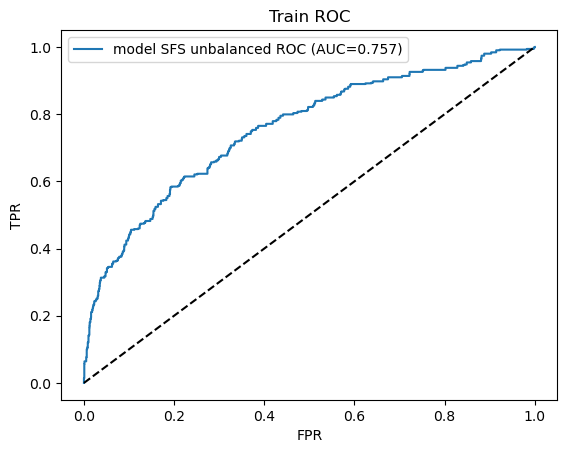

AUC (model SFS unbalanced, Train): 0.757


In [144]:
cm_df_SFS_un, auc_f1_SFS_un = evaluate_model_plot(attrition_train, modelSFS_unbalanced, 'Attrition_lab',
    selected_cols  , score=0.5, model_name='model SFS unbalanced', dataset_name='Train')


In-sample confusion matrix (threshold = 0.5):

Precision (train): 0.692
Recall (train):    0.699


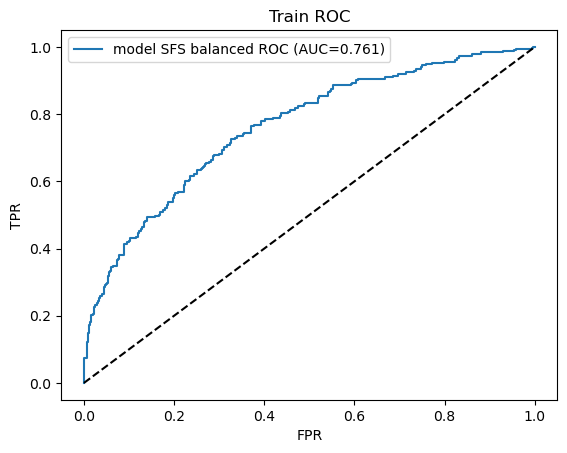

AUC (model SFS balanced, Train): 0.761


In [145]:
cm_df_SFS_bal, auc_f1_SFS_bal = evaluate_model_plot(attrition_train_bal, modelSFS, 'Attrition_lab',
    selected_cols  , score=0.5, model_name='model SFS balanced', dataset_name='Train')

In [146]:
test_probs_SFS_un = modelSFS_unbalanced.predict(sm.add_constant(attrition_test[selected_cols]))
test_probs_SFS_bal = modelSFS.predict(sm.add_constant(attrition_test[selected_cols]))
auc_test_SFS_un = roc_auc_score(attrition_test["Attrition_lab"], test_probs_SFS_un)
auc_test_SFS_bal = roc_auc_score(attrition_test["Attrition_lab"], test_probs_SFS_bal)
test_auc_SFS = pd.DataFrame({
    "Model": ["model SFS unbalanced", "model SFS balanced"],
    "AUC": [auc_test_SFS_un, auc_test_SFS_bal]
})
test_auc_SFS

Model       AUC
0  model SFS unbalanced  0.725957
1    model SFS balanced  0.721808

---

# lets try to create a more comprehensive model. Now that we have used SFS to find the best features to use (selected_cols)

#### Explore scaling the data and using pipelines to impute instead of using the medium, will try to feature engineer within the CV
- recap: the balanced dataset is attrition_train_bal , attrition_test
- model_1_features , model_2_features, model_3_features, model_4_features, predictors , and selected_cols


In [ ]:
## need to standardize 



